In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [18]:
import os
from PIL import Image
import itertools

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


# Preprocessing

In [19]:
train_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [20]:
df

filepaths      label
0     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
...                                                 ...        ...
5211  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5212  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5213  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5214  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5215  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

[5216 rows x 2 columns]

In [21]:
# Preprocessing Valid Dataset

valid_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [22]:
valid

filepaths      label
0   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
5   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
6   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
7   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
8   /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
9   /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
10  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
11  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
12  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
13  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
14  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
15  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

In [23]:
# Preprocessing Test Dataset

test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)


In [24]:
test

filepaths      label
0    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
..                                                 ...        ...
619  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
620  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
621  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
622  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
623  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

[624 rows x 2 columns]

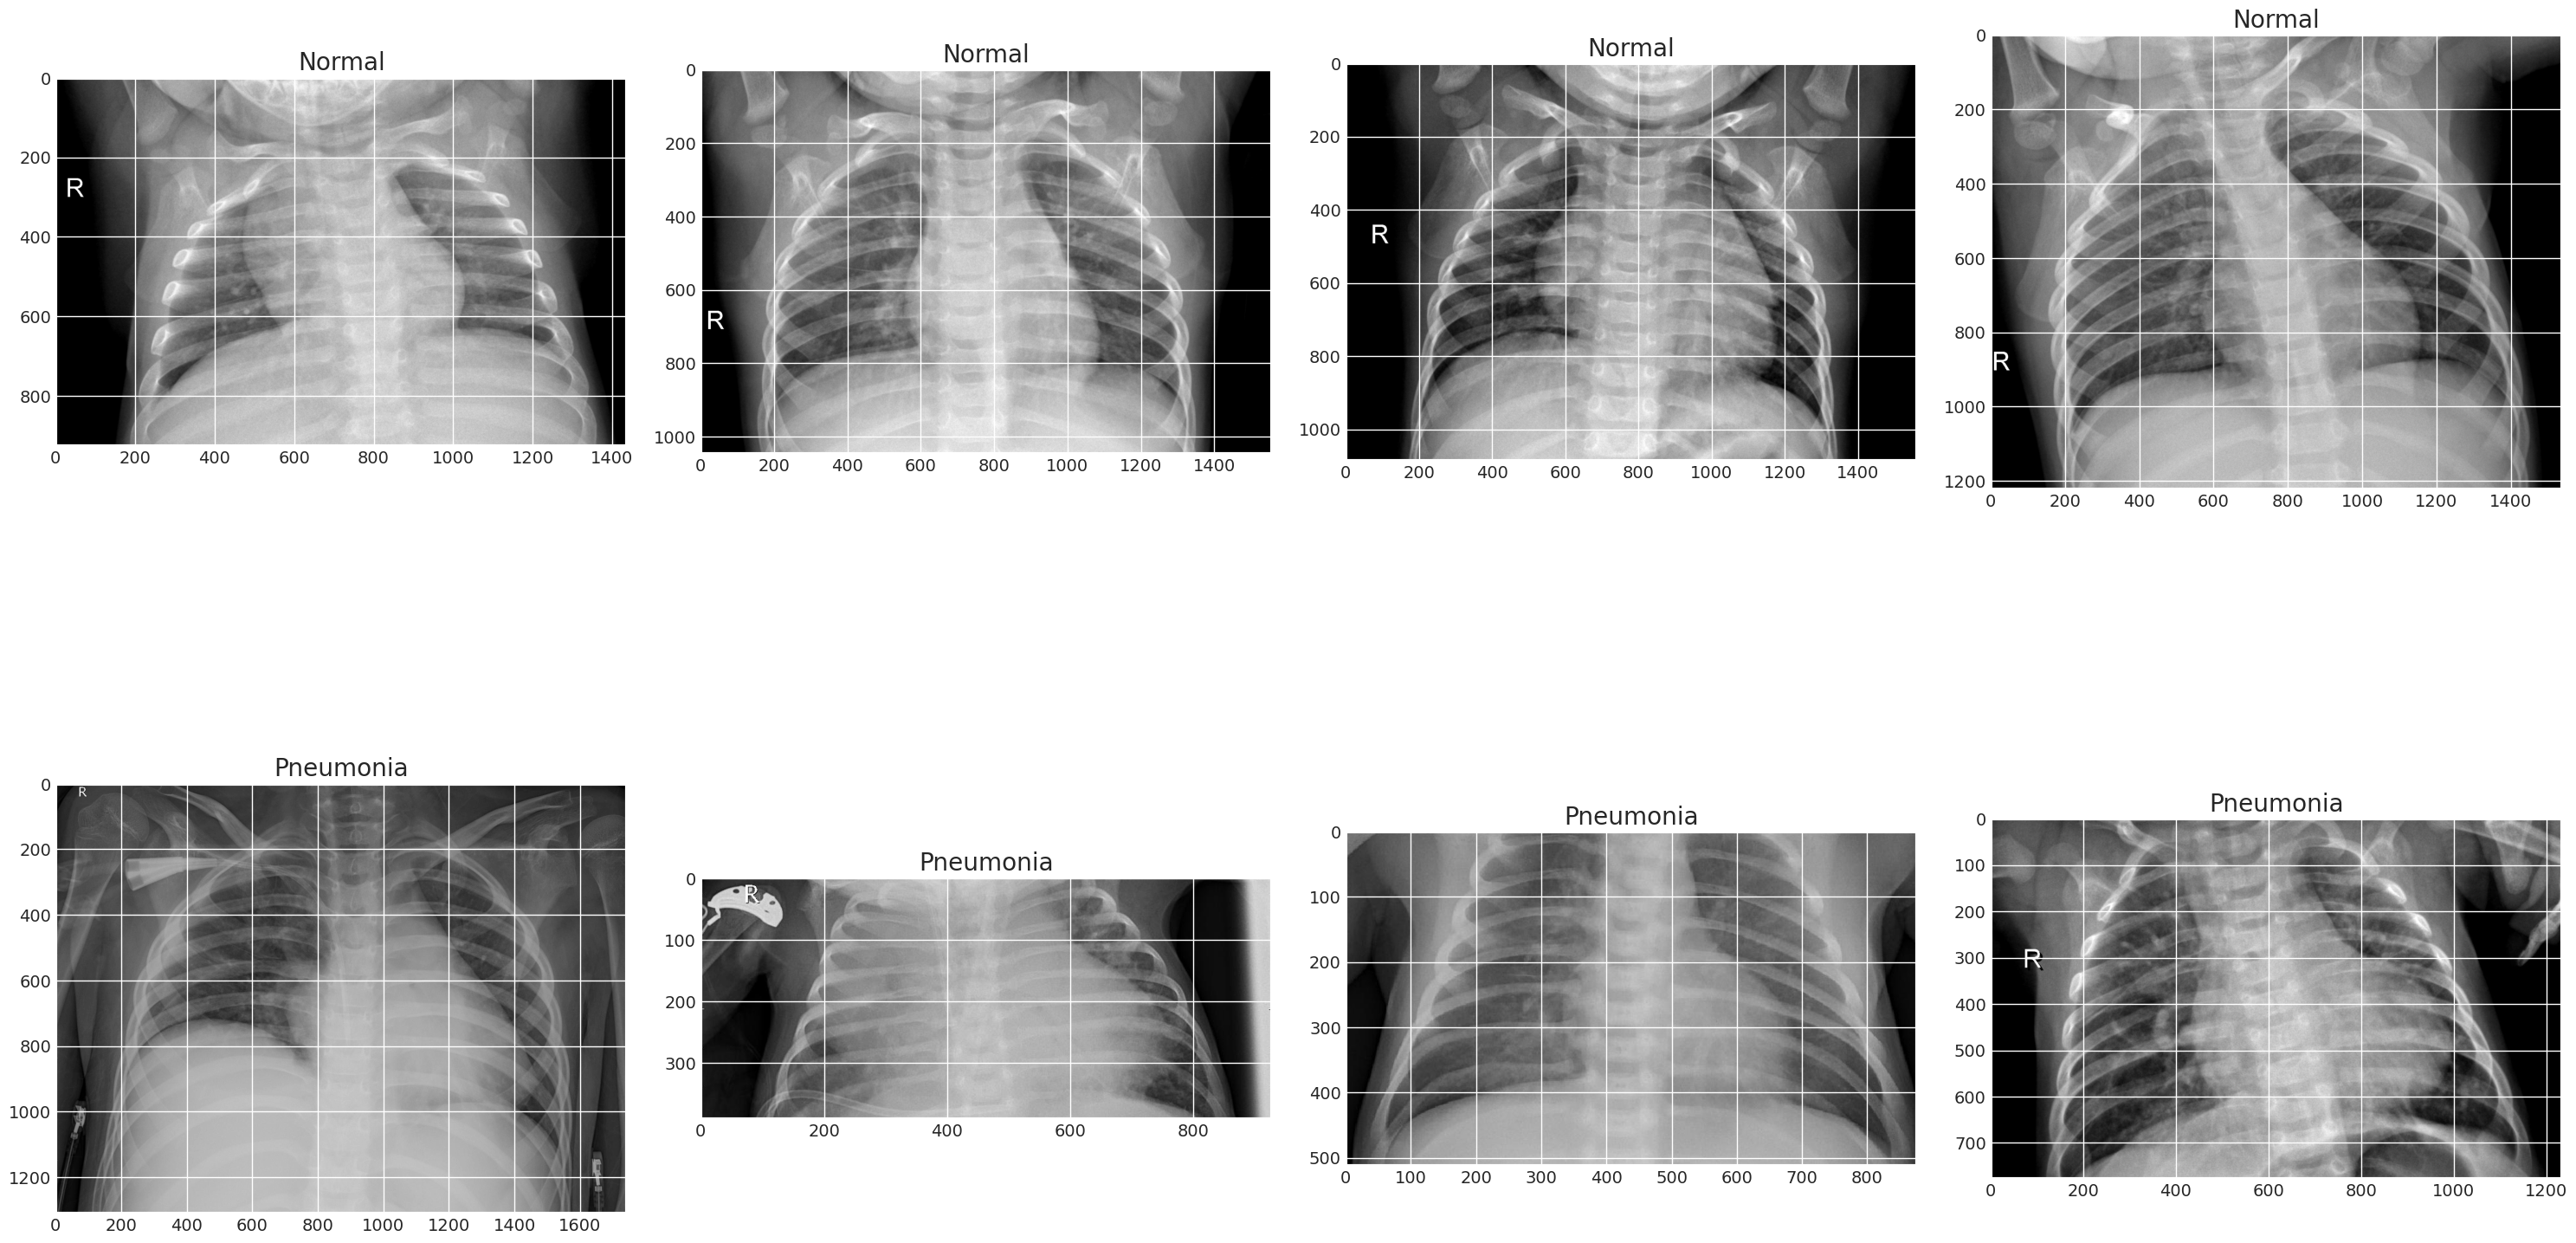

In [25]:
import matplotlib.pyplot as plt
import random

# Preprocessing Train Dataset
train_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
df = pd.concat([FSeries, LSeries], axis=1)

# Visualize some normal and pneumonia images
plt.figure(figsize=(30, 20))

# Display 4 normal images
plt.subplot(2, 4, 1)
normal_images = df[df['label'] == 'NORMAL']['filepaths'].tolist()
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

plt.subplot(2, 4, 2)
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

plt.subplot(2, 4, 3)
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

plt.subplot(2, 4, 4)
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

# Display 4 pneumonia images
plt.subplot(2, 4, 5)
pneumonia_images = df[df['label'] == 'PNEUMONIA']['filepaths'].tolist()
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.subplot(2, 4, 6)
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.subplot(2, 4, 7)
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.subplot(2, 4, 8)
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.tight_layout()
plt.show()

# Image Generator

In [26]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=1)

batch_size = 64
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


# Model Layers and Training

In [27]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation

def attention_block(input_tensor, filters):
    # First convolution layer
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_tensor)
    conv1 = Activation('relu')(conv1)

    # Second convolution layer
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)

    # Attention Mechanism
    attn = Add()([conv1, conv2])
    attn = Activation('relu')(attn)
    attn = Conv2D(1, (1, 1), padding='same')(attn)
    attn = Activation('softmax')(attn)

    # Multiply the input (features) with the attention map
    output_tensor = Multiply()([input_tensor, attn])

    return output_tensor

# Define the model
input_tensor = keras.Input(shape=(224, 224, 3))
x = attention_block(input_tensor, 64)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = attention_block(x, 128)

# another layer
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = attention_block(x, 256)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)  # Added dense layer
x = Dense(64, activation='relu')(x)  # Added another dense layer
output_tensor = Dense(2, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, validation_data=valid_gen, verbose = 1, epochs=6, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')




Epoch 1/6


W0000 00:00:1713417555.619229      84 hlo_rematerialization.cc:2946] Can't reduce memory use below 9.86GiB (10587338585 bytes) by rematerialization; only reduced to 11.31GiB (12147129976 bytes), down from 12.15GiB (13049148328 bytes) originally


66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 631ms/step - accuracy: 0.7921 - loss: 836.8883 - val_accuracy: 0.9157 - val_loss: 0.8527
Epoch 2/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 606ms/step - accuracy: 0.9540 - loss: 0.4248 - val_accuracy: 0.9444 - val_loss: 0.3837
Epoch 3/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 597ms/step - accuracy: 0.9909 - loss: 0.0624 - val_accuracy: 0.9559 - val_loss: 0.2717
Epoch 4/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 613ms/step - accuracy: 0.9935 - loss: 0.0281 - val_accuracy: 0.9617 - val_loss: 0.2428
Epoch 5/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 619ms/step - accuracy: 0.9975 - loss: 0.0089 - val_accuracy: 0.9540 - val_loss: 0.2906
Epoch 6/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 611ms/step - accuracy: 0.9967 - loss: 0.0118 - val_accuracy: 0.9713 - val_loss: 0.2058
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.9500 - loss: 0.4021
Test loss: 0.4498900771141052, Test accuracy: 0.9578543901443481


# Evaluation

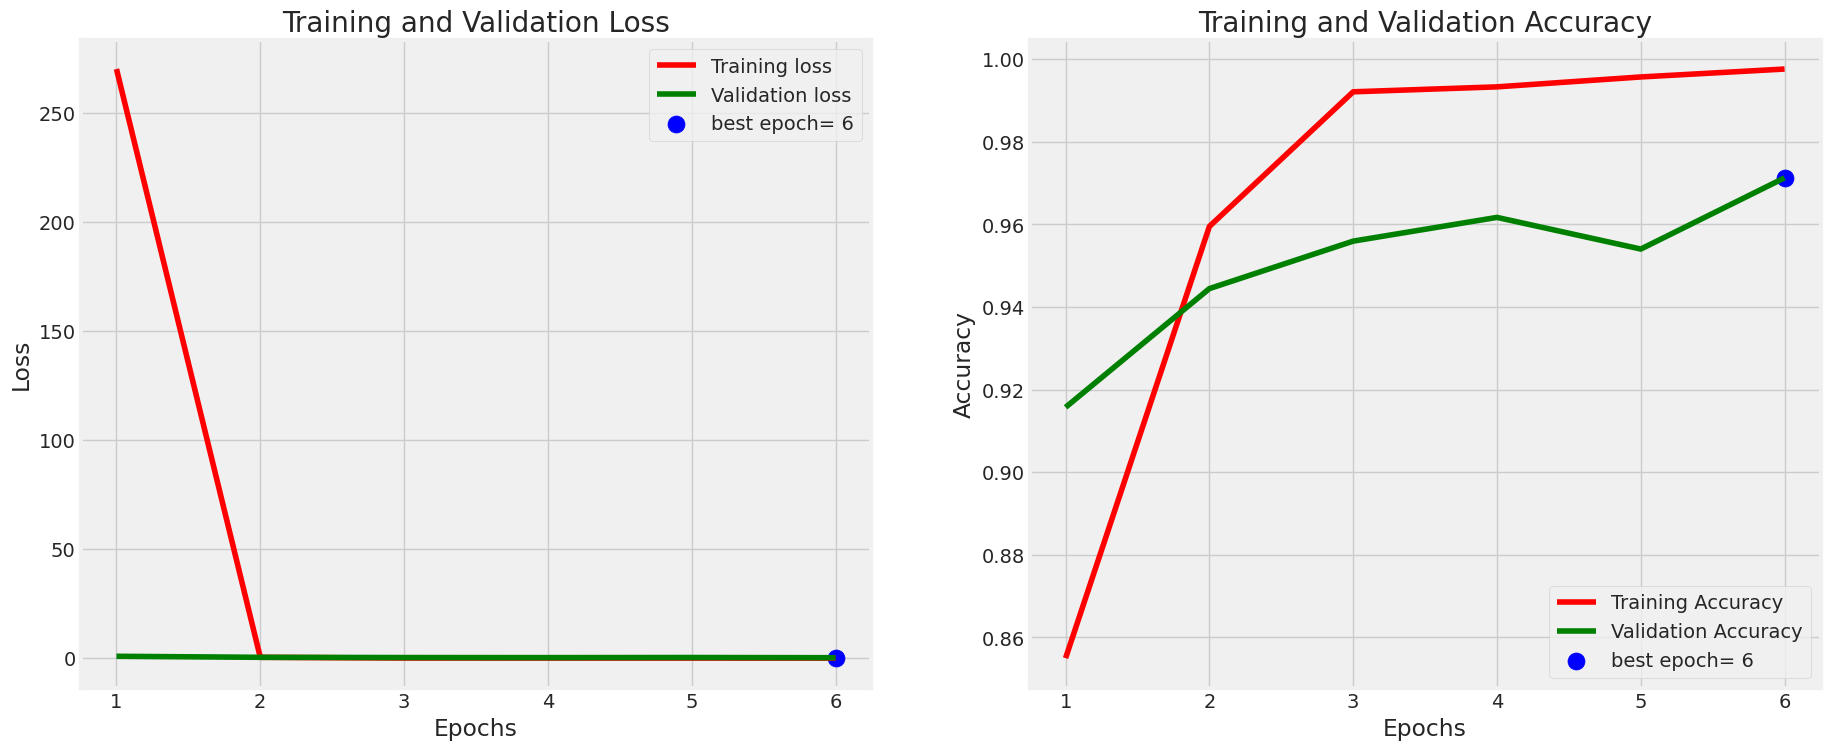

66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 569ms/step - accuracy: 1.0000 - loss: 9.8474e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.9737 - loss: 0.2077
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step - accuracy: 0.9500 - loss: 0.4021
Train Loss:  0.001173070166260004
Train Accuracy:  1.0
--------------------
Validation Loss:  0.2181340754032135
Validation Accuracy:  0.9712643623352051
--------------------
Test Loss:  0.4498900771141052
Test Accuracy:  0.9578543901443481


In [28]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       142
           1       0.97      0.97      0.97       380

    accuracy                           0.96       522
   macro avg       0.95      0.95      0.95       522
weighted avg       0.96      0.96      0.96       522



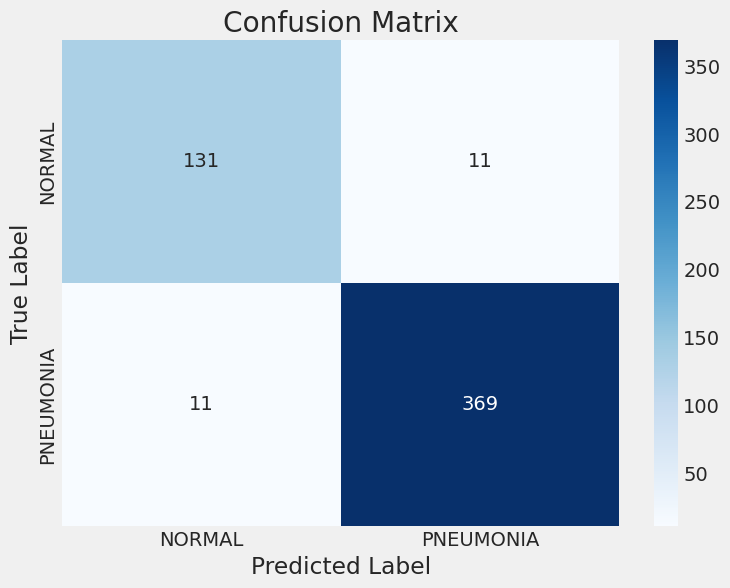

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [30]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 224, 224,  │          0 │ conv2d_7[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │     36,928 │ activation_8[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 224, 224,  │          0 │ conv2d_8[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ activation_8[0][… │
│                     │ 64)               │            │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 224, 224,  │          0 │ add_2[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │         65 │ activation_10[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 224, 224,  │          0 │ conv2d_9[0][0]    │
│ (Activation)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Multiply)          │ 3)                │            │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 224, 224,  │      3,584 │ multiply_2[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 112, 112,  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 112, 112,  │    147,584 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 112, 112,  │          0 │ conv2d_11[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 112, 112,  │          0 │ conv2d_12[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 112, 112,  │          0 │ activation_12[0]

 Total params: 617,601,230 (2.30 GB)

 Trainable params: 205,867,076 (785.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 411,734,154 (1.53 GB)

# Saving and Inference

In [31]:
# # Save the model
# model.save('/kaggle/working/Classfication_model.h5')

In [32]:
from tensorflow.keras.models import load_model
from PIL import Image

# Load the saved model
loaded_model = model

# Define class labels
class_labels = ["NORMAL", "PNEUMONIA"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Repeat grayscale image to have 3 channels
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    return predicted_class, probability

# Example usage
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0119-0001.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Predicted Class: NORMAL
Probability: 0.56921095
